# VALOR quickstart (interactive)

Walk through the VALOR reasoning pipeline step by step—mirroring the eval harness but with visible outputs. Fill in the image path + query, run cells in order, and inspect the plan, code, and execution logs.


In [1]:
from notebook_imports import *

setup_env()
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model_path = "glab-caltech/VALOR-8B"
system_prompt_path = DEFAULT_PROMPT_PATH

/data/damiano/miniconda3/envs/model-eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


VALOR requires an OpenAI API key for VQA. Set it below.

In [2]:
from getpass import getpass

# This will NOT show your key as you type
openai_api_key = getpass("Enter your OpenAI API key: ")

# Set it in the environment for this kernel
os.environ["OPENAI_API_KEY"] = openai_api_key

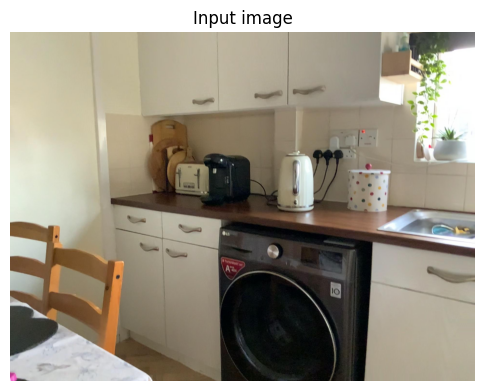

In [3]:
image_path = "demo.jpg" 
image = load_image(image_path)
show_image(image)

In [4]:
query = "Which object is closer to the camera: the washing machine or the kettle? Options: {washing machine, kettle}"
ground_truth = "washing machine"

In [5]:
system_prompt, tokenizer, model = load_model_and_prompt(
    model_path=model_path,
    device=device,
    system_prompt_path=system_prompt_path,
)
show_md(f"Loaded system prompt from `{system_prompt_path}`")

Loading system prompt...
Loading tokenizer...
Loading model...


Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Finished loading model.


Loaded system prompt from `/data/damiano/code/VALOR/valor/prompts/system_prompt.jinja`

In [6]:
raw_response, plan_text, generated_code, parsed = ask_model(
    model, tokenizer, system_prompt, query, device
)

## Generated Plan

In [7]:
display_plan(plan_text)

### Model plan

<pre>1. Use gd_detect on img_pth with prompt "washing machine" to detect the washing machine.
2. Use gd_detect on img_pth with prompt "kettle" to detect the kettle.
3. If either object is not found, store the other object in final_answer and return.
4. For both the washing machine and the kettle, call depth with the object bounding box to get depths for each object (wm_depth, kettle_depth).
5. Compare wm_depth and kettle_depth: the smaller depth value indicates the closer object.
6. If wm_depth < kettle_depth, set final_answer = "washing machine"; otherwise set final_answer = "kettle".</pre>

## Generated Code

In [8]:
display_code(generated_code)

**Generated code**

# Step 1: Detect the washing machine
wm_dets = gd_detect(img_pth, "washing machine")

# Step 2: Detect the kettle
kettle_dets = gd_detect(img_pth, "kettle")

# Step 3: Check detections
if len(wm_dets) == 0:
    final_answer = "kettle"
    return
if len(kettle_dets) == 0:
    final_answer = "washing machine"
    return

# Step 4: Query depths for both objects
wm_depth = depth(img_pth, wm_dets[0]["bbox"])
kettle_depth = depth(img_pth, kettle_dets[0]["bbox"])

# Step 5 & 6: Compare depths (smaller = closer)
if wm_depth < kettle_depth:
    final_answer = "washing machine"
else:
    final_answer = "kettle"

**Model final answer:** washing machine

**Ground truth:** washing machine  
Match: `True`

### Intermediate results

Step 1: `gd_detect` prompt: `washing machine`

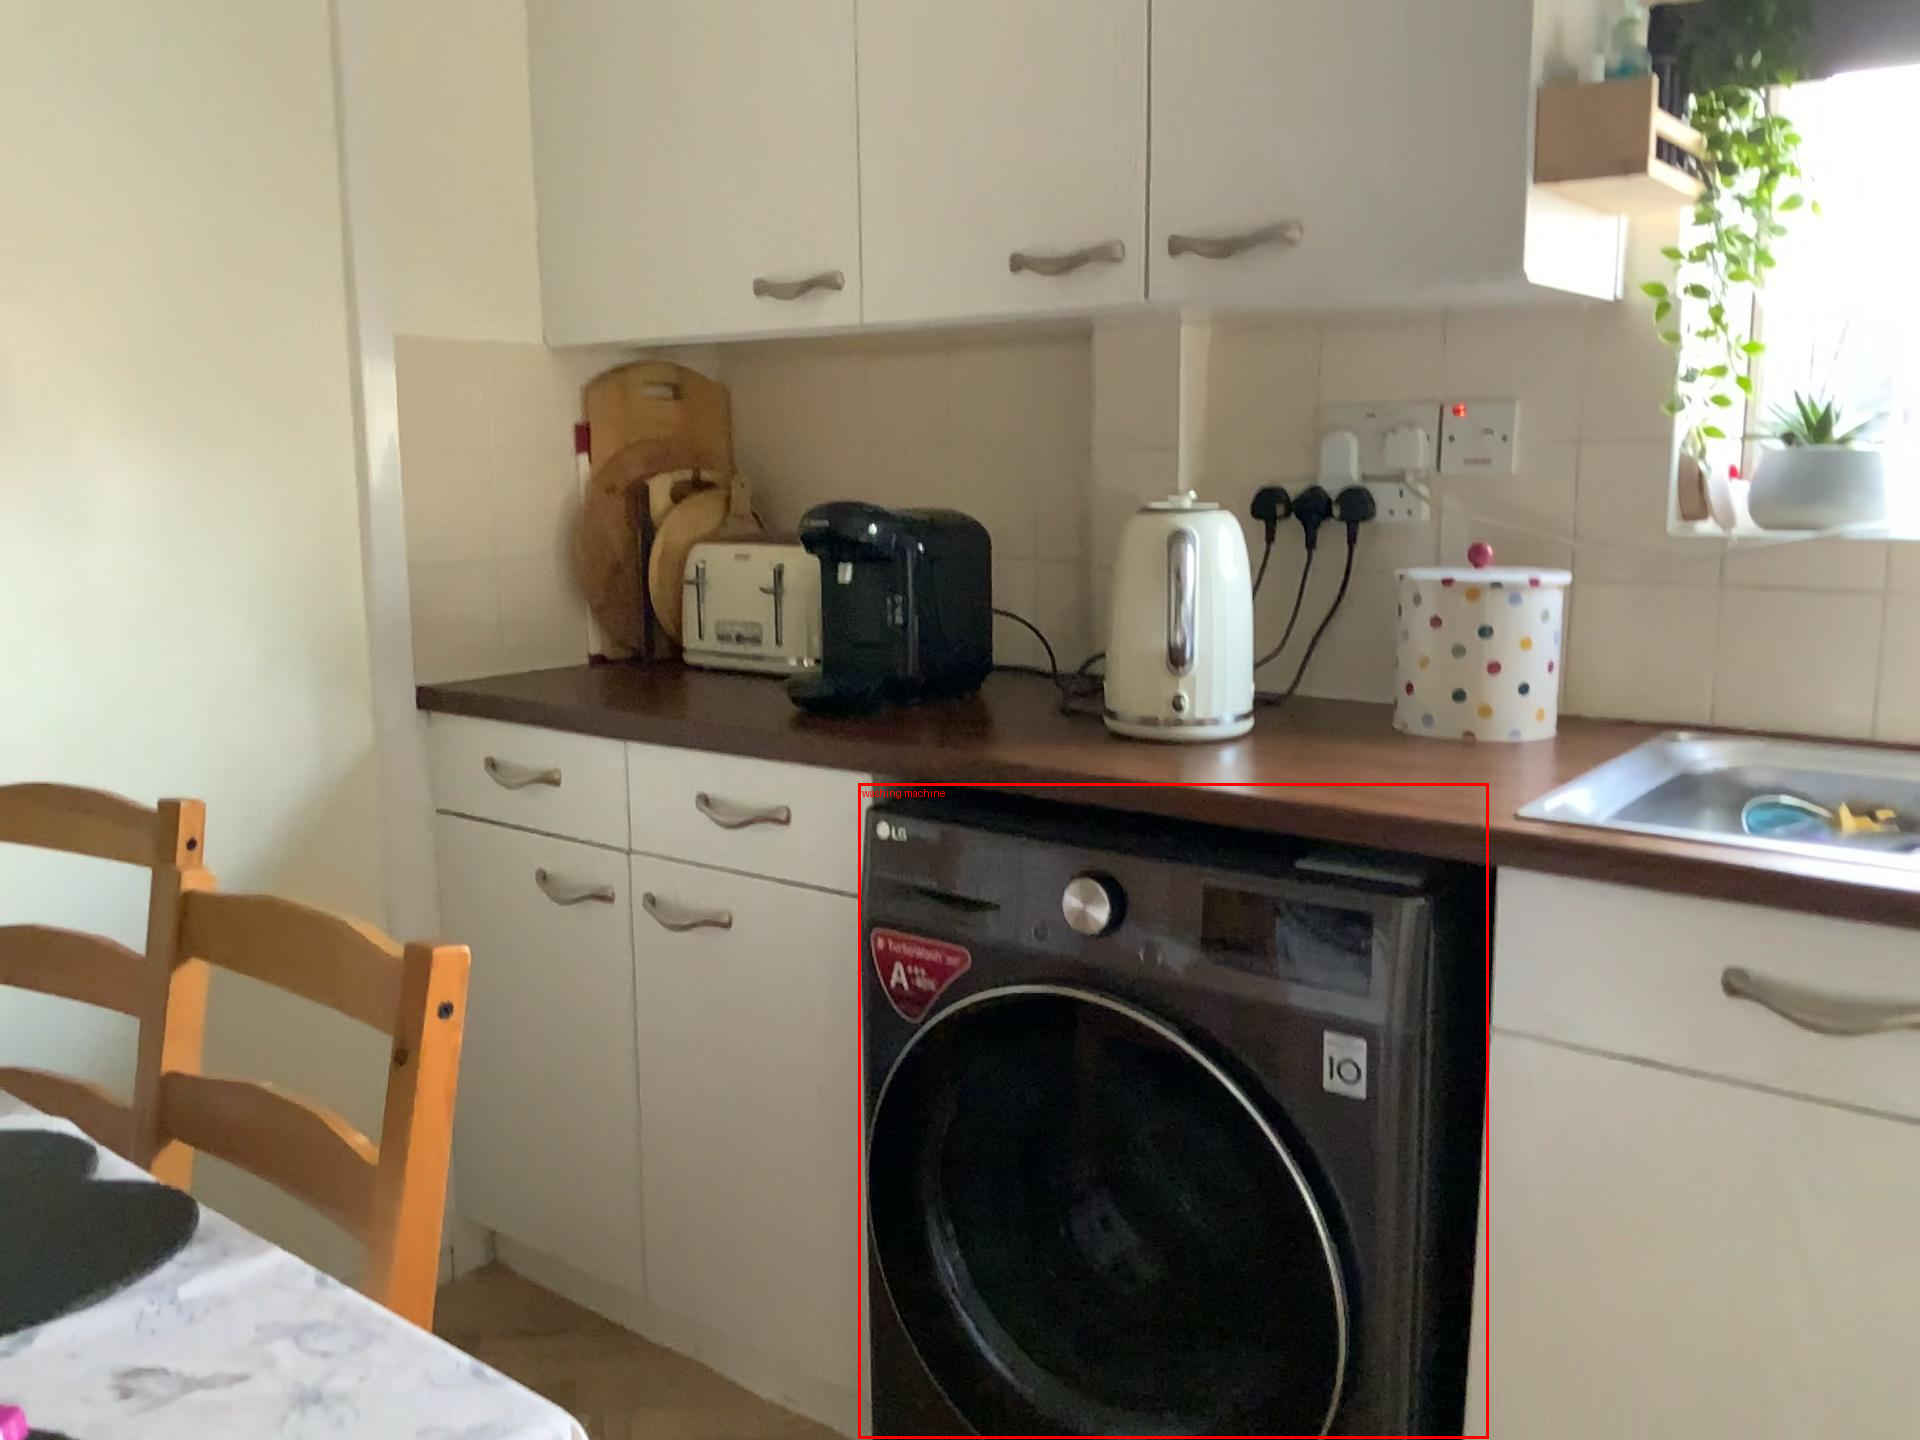

Step 2: `gd_detect` prompt: `kettle`

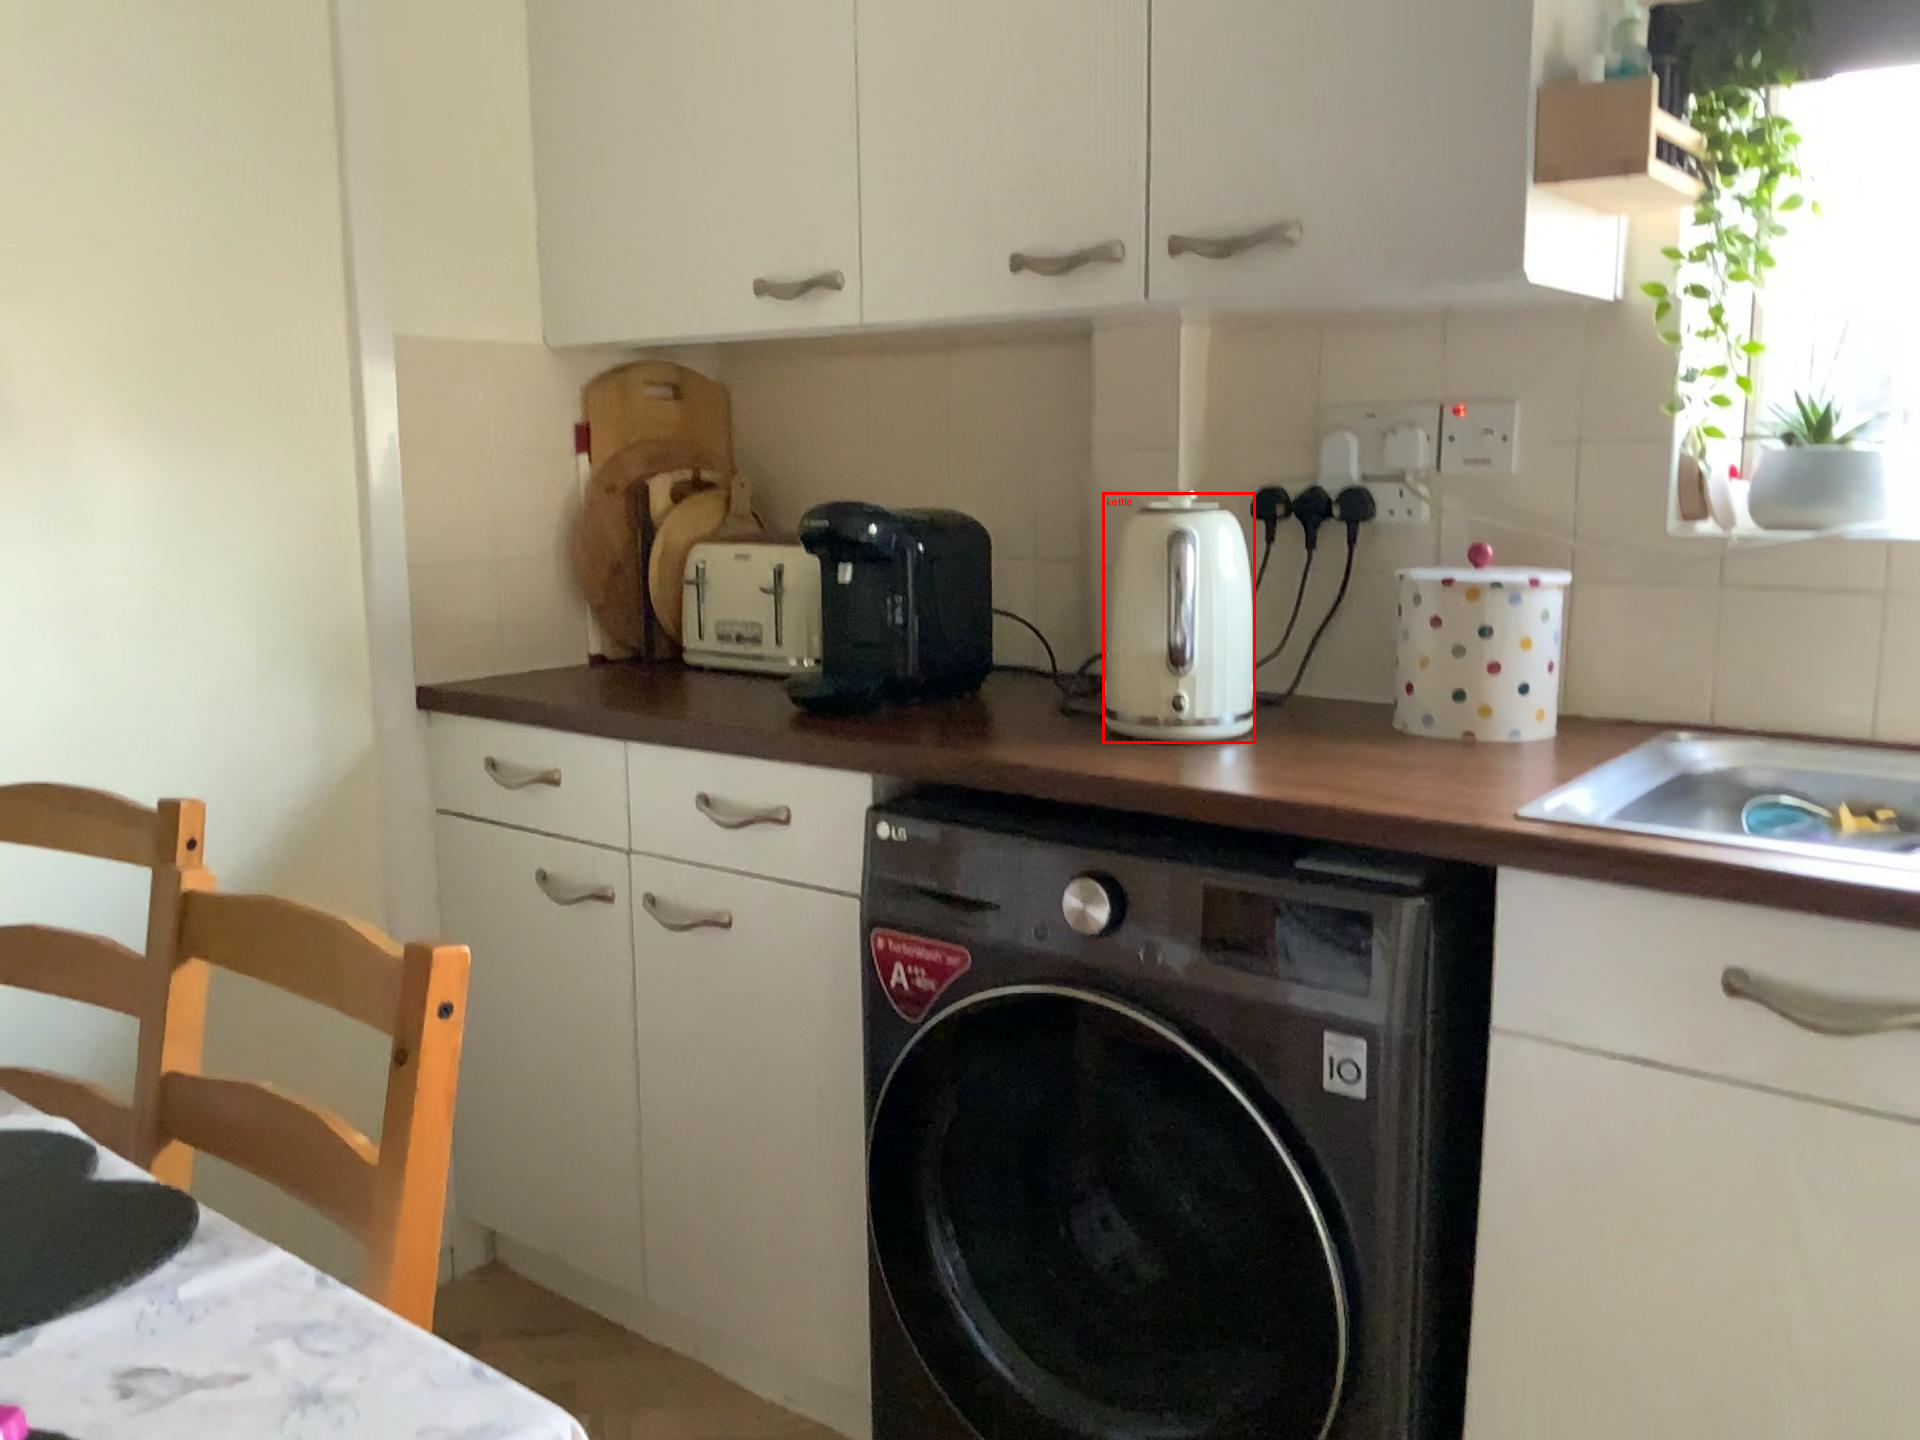

Step 3: `depth` bbox: `[858, 783, 1488, 1438]`, value: `1.4644155502319336`

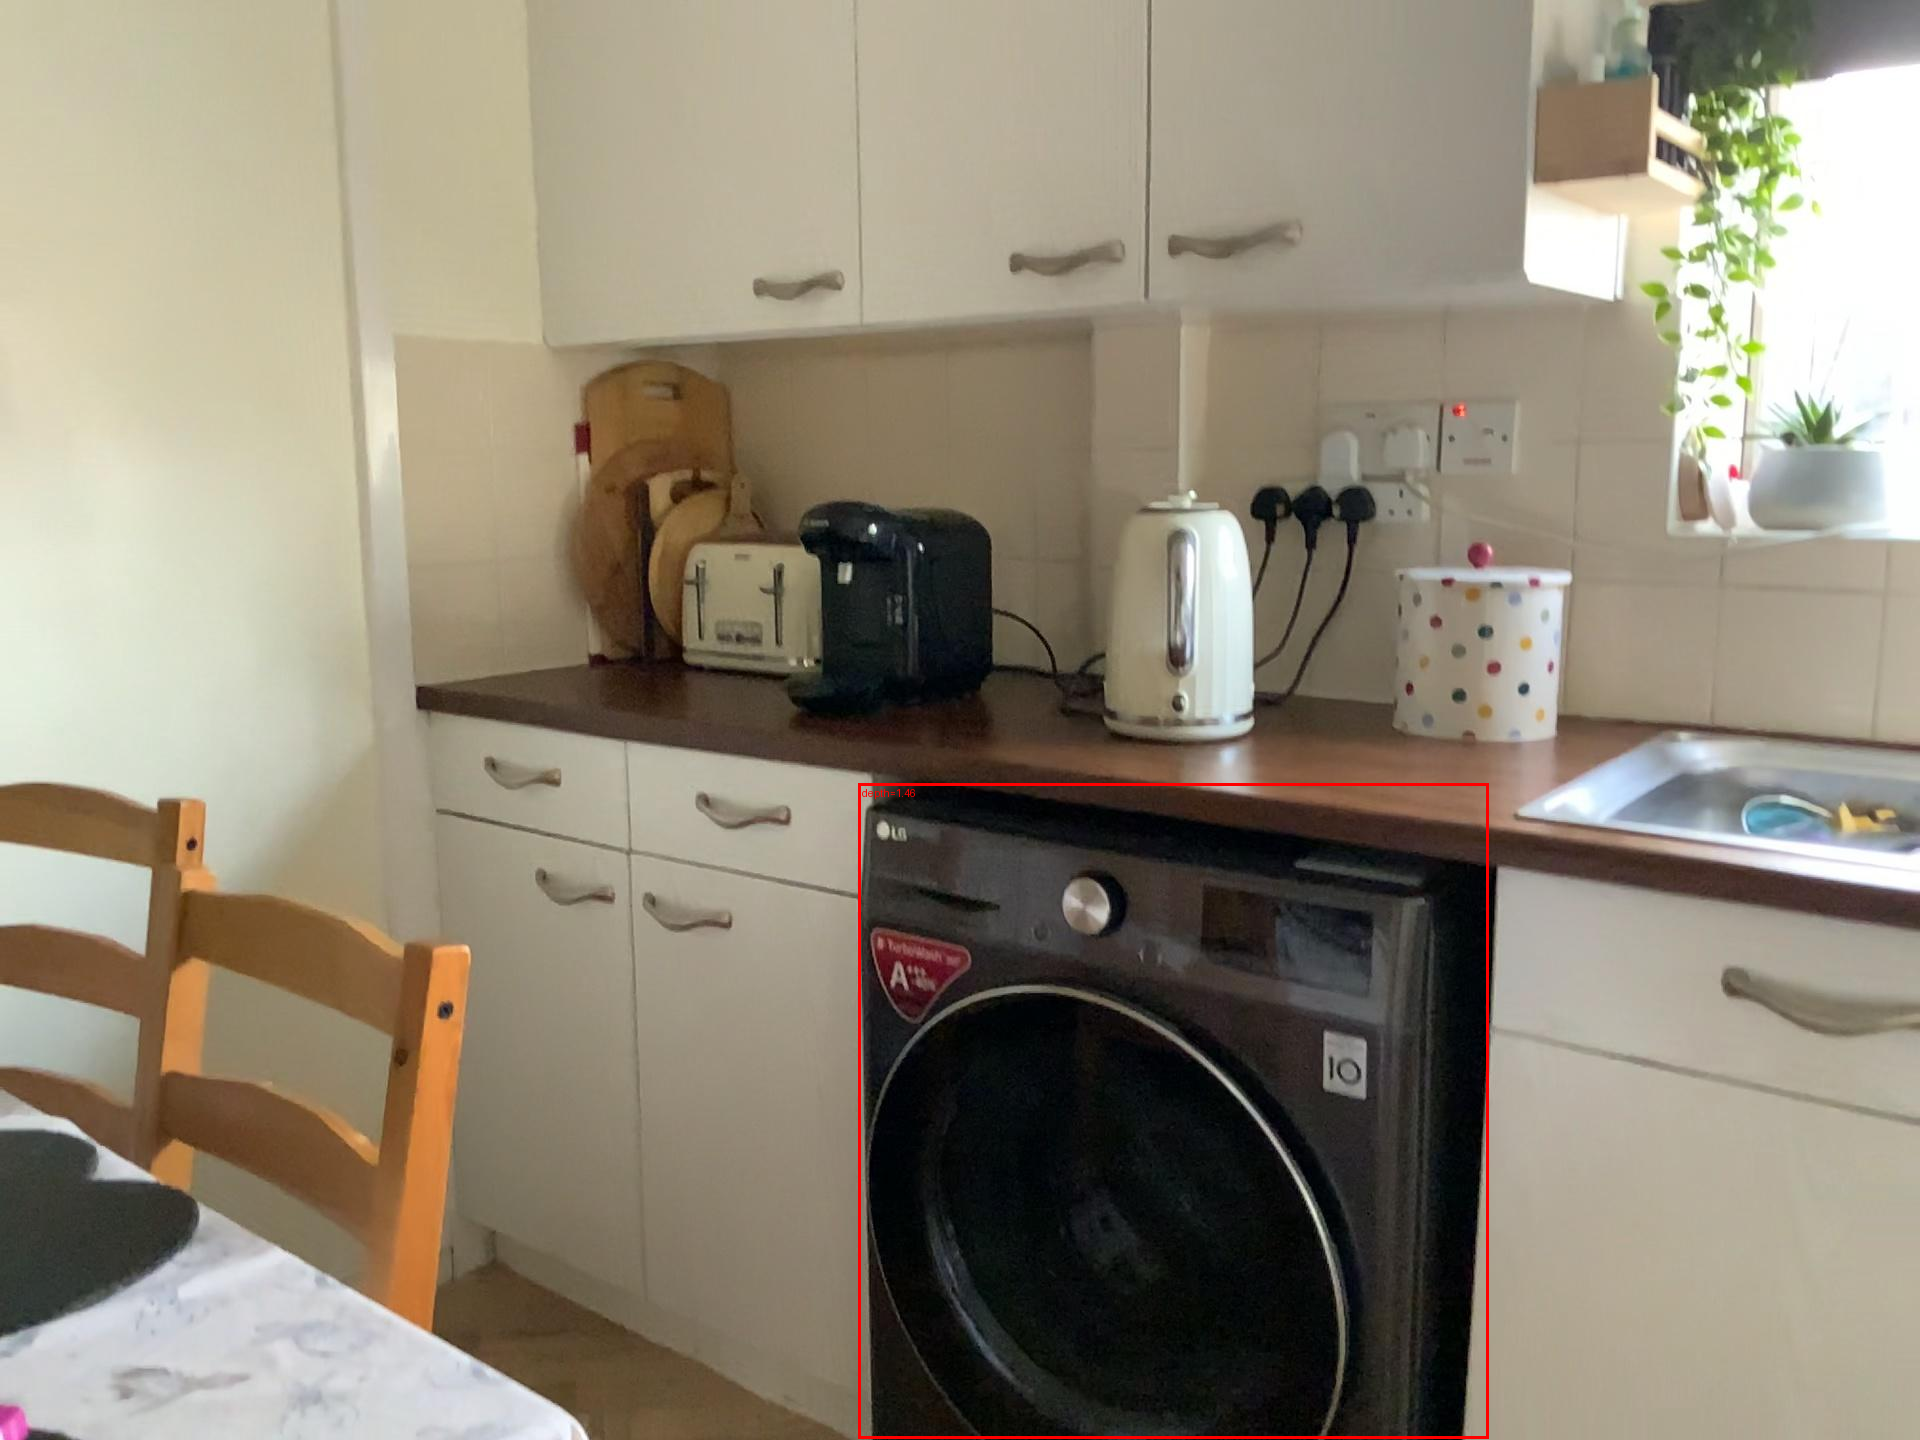

Step 4: `depth` bbox: `[1102, 492, 1255, 743]`, value: `1.6175423860549927`

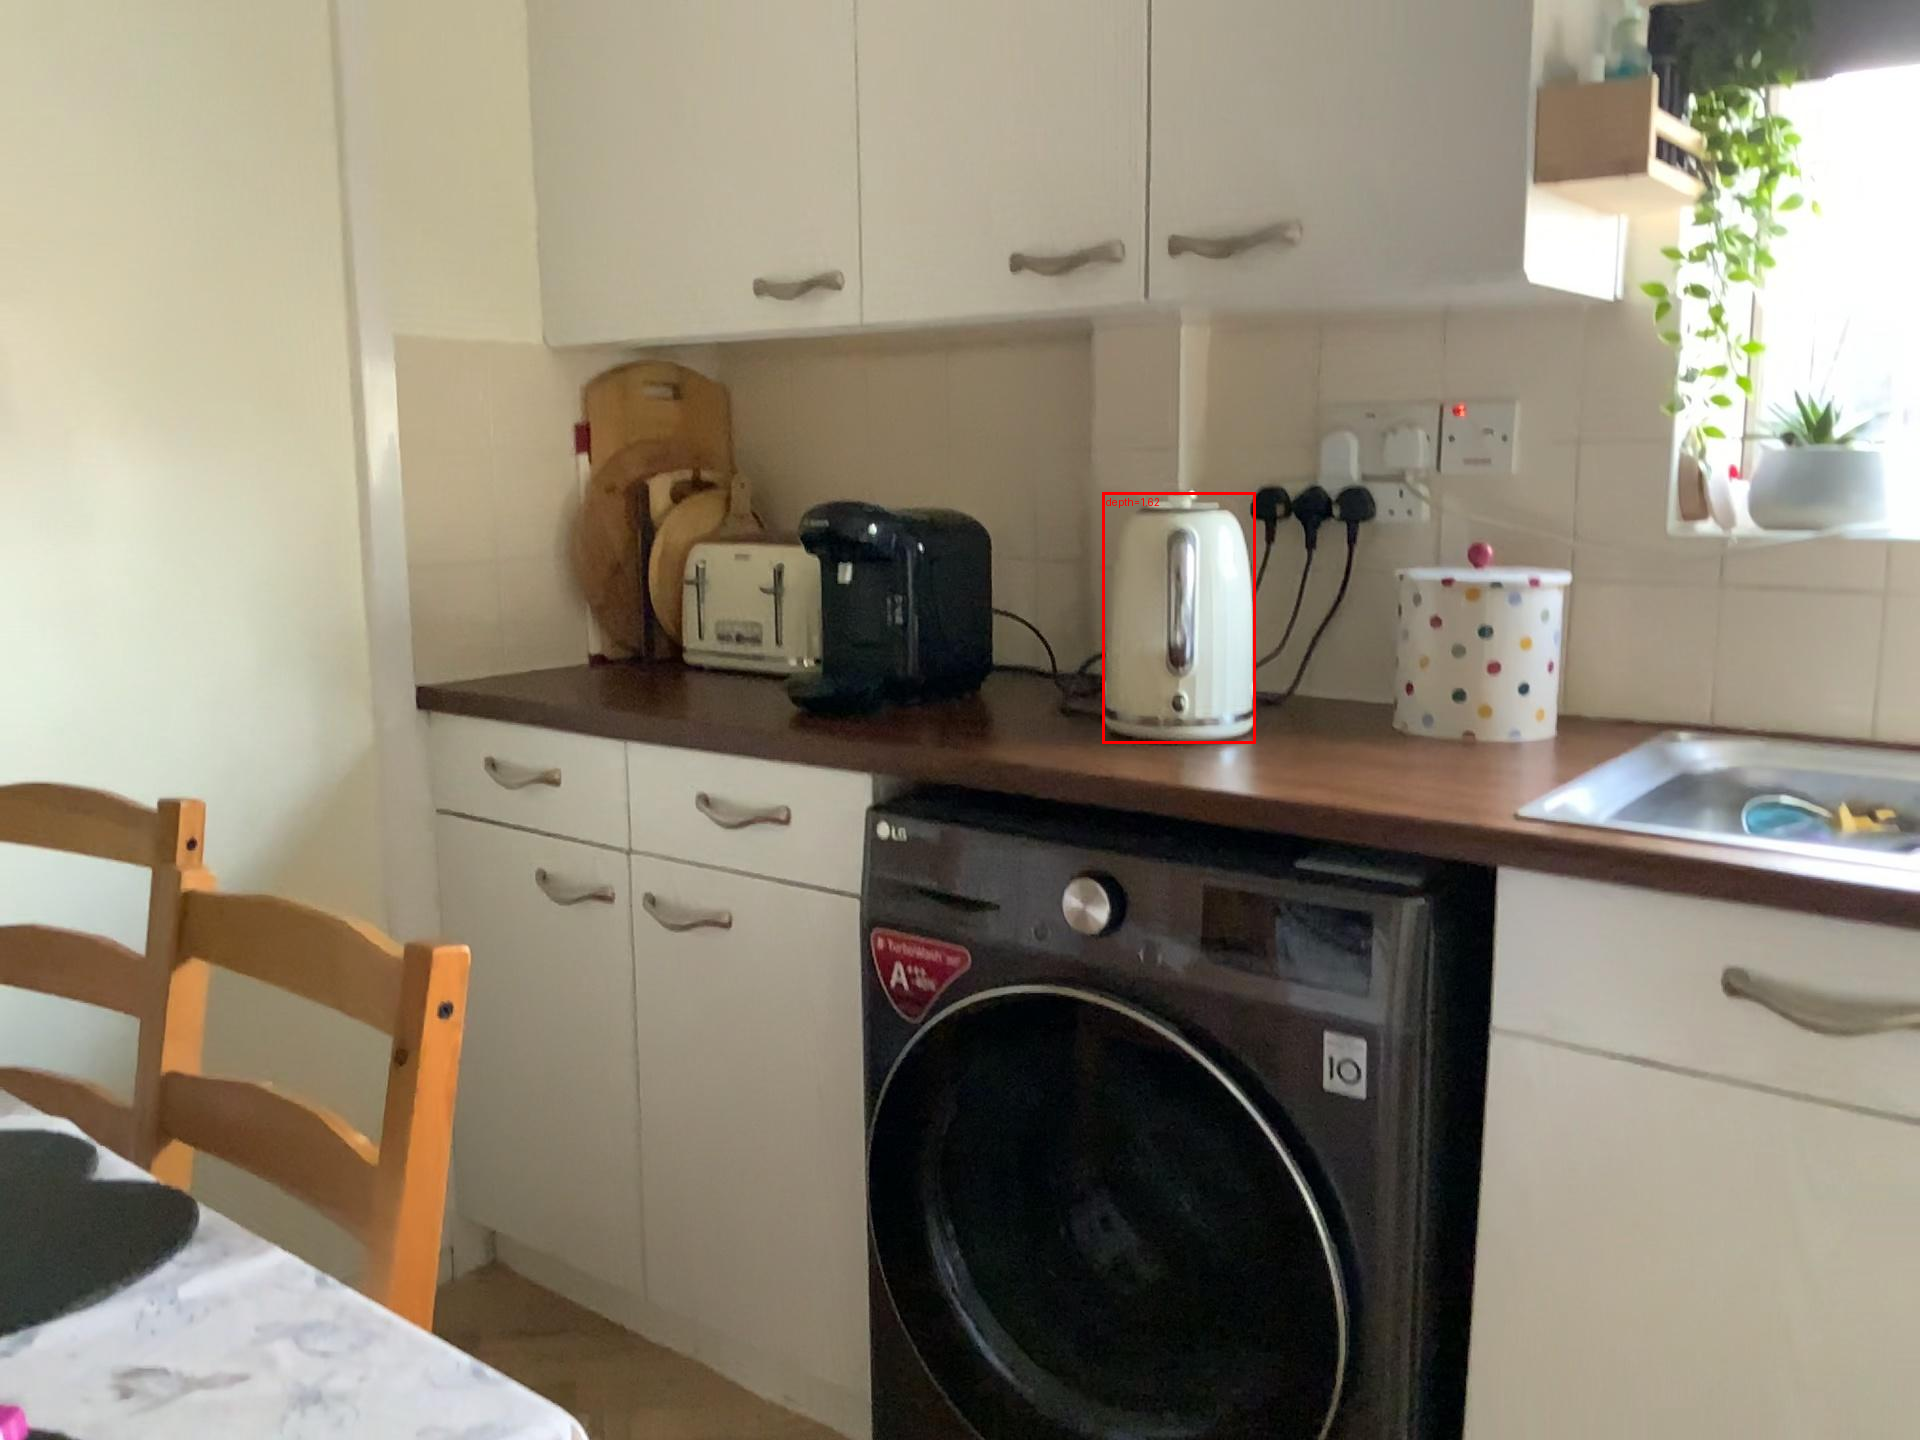

Step 5: `final_answer` = `washing machine`

In [9]:
# Execute the generated code in the sandbox executor
pred_answer = execute_with_logging(
    plan_text,
    generated_code,
    image_path,
    question=query,
    ground_truth=ground_truth,
)
